In [246]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import yfinance as yfin
from pandas_datareader import data as pdr
from pyhhmm.gaussian import GaussianHMM

yfin.pdr_override()
from ta import add_trend_ta
import matplotlib.pyplot as plt

In [247]:
def get_yahoo_data(symbol, start_date, end_date):
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    data = data[["Open", "High", "Low", "Adj Close", "Volume"]]
    return data

In [248]:
start_date = "2020-01-1"
end_date = "2024-08-2"
symbol = "BTC"
data = get_yahoo_data(symbol, start_date, end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Adj Close,Volume
Date,,,,,
2020-10-01,100.000000,100.000000,100.000000,96.285774,0
2020-10-02,100.000000,100.000000,100.000000,96.285774,0
2020-10-05,100.029999,100.040001,99.995003,96.280968,10725
2020-10-06,100.010002,100.029999,100.010002,96.314659,10080
2020-10-07,99.949997,99.959999,99.919998,96.208733,6350
...,...,...,...,...,...
2024-02-01,92.730003,92.944801,92.730003,92.820801,13928
2024-02-02,92.257599,92.257599,92.257599,92.257599,310
2024-02-05,91.879997,91.900002,91.845001,91.845001,375


In [249]:
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
df_trend = add_trend_ta(df.copy(), high="High", low="Low", close="Adj Close", fillna=True)
df.head()

,Open,High,Low,Adj Close,Volume,Returns,Range
Date,,,,,,,
2020-10-02,100.000000,100.000000,100.000000,96.285774,0,0.000000,0.000000
2020-10-05,100.029999,100.040001,99.995003,96.280968,10725,-0.000050,0.000450
2020-10-06,100.010002,100.029999,100.010002,96.314659,10080,0.000350,0.000200
2020-10-07,99.949997,99.959999,99.919998,96.208733,6350,-0.001100,0.000400
2020-10-08,99.989998,99.995003,99.971703,96.280968,650,0.000751,0.000233


In [250]:
df["MA_12"] = df_trend["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df_trend["Adj Close"].rolling(window=21).mean()

In [251]:
# X_train = df[["Returns", "Range", "trend_adx", "trend_macd"]]
df_dataset = df.iloc[:500]
X_train = df_trend[["Returns", "Range", "trend_adx", "trend_macd"]].iloc[:500]
X_test = df_trend[["Returns", "Range", "trend_adx", "trend_macd"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  342
X_train From:  2020-10-02 00:00:00
X_train To:  2022-09-27 00:00:00
X_test From:  2022-09-28 00:00:00
X_test To:  2024-02-07 00:00:00


In [252]:
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=4)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [253]:
hidden_states = model.predict([X_train.values])[0]
print(hidden_states[:40])
len(hidden_states)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


500

In [254]:
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df_dataset["Adj Close"].values.astype(float)
print(len(prices), len(hidden_states))
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
        labels_3.append(float('nan'))
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])
    i += 1

500 500
Correct number of rows:  True


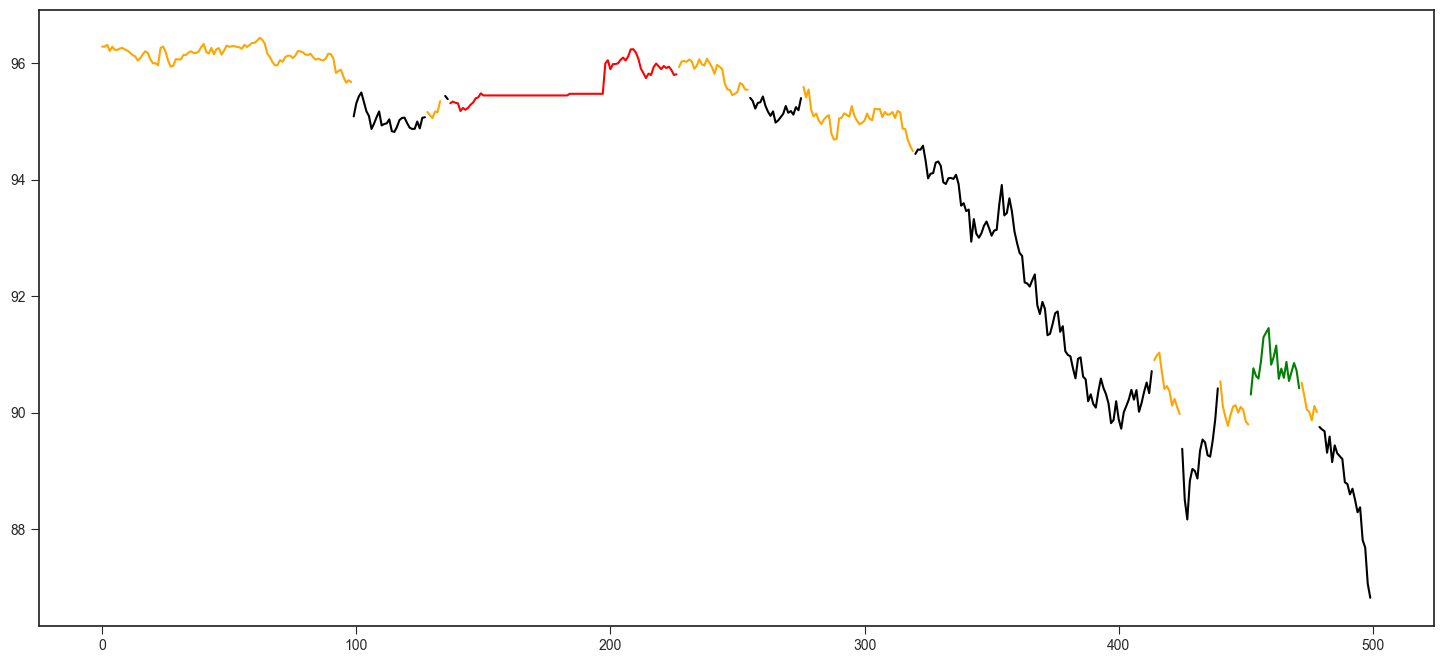

In [255]:
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, color="green")
plt.plot(labels_1, color="red")
plt.plot(labels_2, color="orange")
plt.plot(labels_3, color="black")
plt.show()

In [256]:
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

[0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,,
2022-09-28,89.732903,87.651230,877,0.009562,0.004653,88.088873,88.652760,0
2022-09-29,89.790001,87.396957,1090,-0.002901,0.000557,87.971633,88.542547,3
2022-09-30,90.000000,87.260147,2654,-0.001565,0.003656,87.845444,88.427275,3
2022-10-03,90.269997,87.828827,738,0.006517,0.001953,87.781437,88.356642,3
2022-10-04,90.580002,88.012741,157,0.002094,0.001486,87.724690,88.281582,3


In [257]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [258]:
# Add HMM Signals
favourable_states = [0, 1]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [259]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [260]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [261]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [262]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Volume,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,,
2024-01-31,92.592903,92.503601,637,0.003731,0.000965,92.048800,92.076281,0,0.0,1,0.0,0.003724,0.053882,0.055360,0.000000,0.017346,0.017497
2024-02-01,92.730003,92.820801,13928,0.003429,0.002316,92.101792,92.103938,0,0.0,1,0.0,0.003423,0.057305,0.058979,-0.000000,0.017346,0.017497
2024-02-02,92.257599,92.257599,310,-0.006068,0.000000,92.129200,92.106205,0,1.0,1,0.0,-0.006086,0.051219,0.052553,-0.000000,0.017346,0.017497
2024-02-05,91.879997,91.845001,375,-0.004472,0.000599,92.122533,92.101443,0,1.0,1,1.0,-0.004482,0.046737,0.047846,0.003260,0.020606,0.020820
2024-02-06,92.180000,92.169998,1046,0.003539,0.000543,92.149892,92.117395,0,1.0,1,1.0,0.003532,0.050269,0.051554,0.000325,0.020931,0.021152


In [263]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [264]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [265]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: 5.2%
Returns Strategy: 2.1%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: 0.6
Sharpe Strategy: 0.2


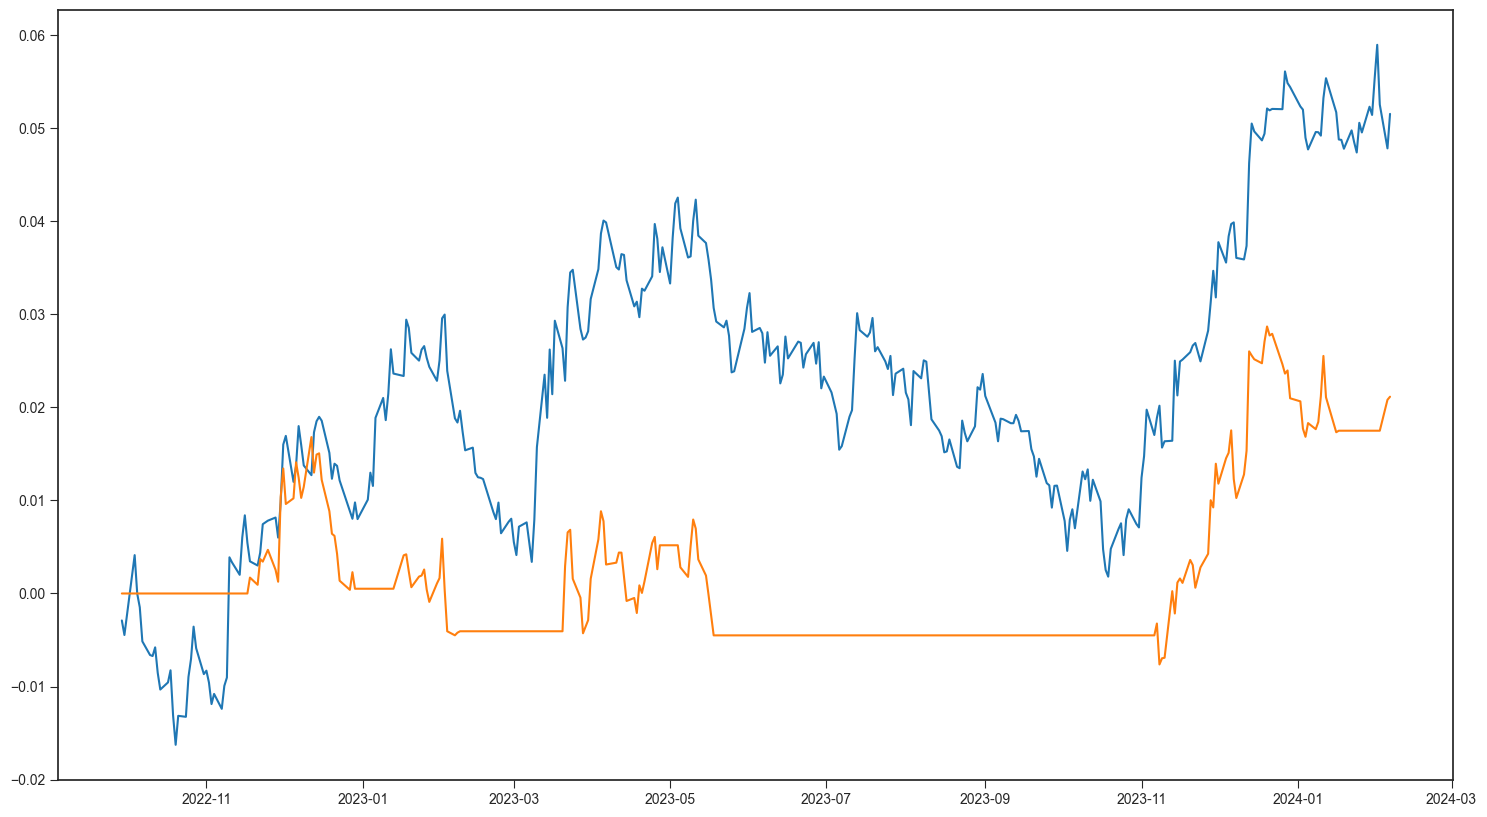

In [266]:
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_prod_exp"])
plt.plot(df_main["strat_prod_exp"])
plt.show()